# **1 导入部分**

## **1.1 数据包与通用方法**

在项目开始之前，我想首先导入一些基本的扩展包、和我常用的函数工具，它们分别是：
- **show_df**：展示目前数据帧对象每一个字段的数据类型、唯一值数目和缺失值数目；

In [2]:
# 导入数据包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import re
warnings.filterwarnings('ignore')

# 工具1：展示df的基本属性
def show_df(df):
    return pd.DataFrame({
                'col' : df.columns.tolist(),
                'dtype' : [df[item].dtype for item in df.columns.tolist()],
                'uniqueVals' : [df[item].unique().shape[0] for item in df.columns.tolist()],
                'missingVals' : [df[item].isnull().sum() for item in df.columns.tolist()]
            }).sort_values(by='missingVals', ascending=False)

### **1.1 通过数据库建立表单查询**

- 正如在[Anjuke_csp.ipynb]()中提到的一样，数据库查询会基于mydb和sql：
    - mydb 专门用于存储数据库查询的类，并调用sql中的语句完成整体查询流程；
    - 这里我选择通过pd.read_sql简化查询流程；

In [27]:
# from mydb import mydb
# from sql import *

# host = "localhost"
# user = "root"
# password = "123"
# database = "py_database_anjuke"

# # 建立db查询对象
# db = mydb(host, user, password, database)
# db.connect() # 初始化链接、游标
# # 存储查询结果（pd.DataFrame类型）至两变量
# house = pd.read_sql(sql_query_house, db.db)
# community = pd.read_sql(sql_query_community, db.db)

# # 将两表进行联立，得到大表，方便后续分析
# house = house.merge(community, on='COMM_NAME')

# # 去除无用的字段
# house = house[[x for x in house.columns if x not in ['HOUSE_INDEX']]]

# # 字段转换为小写（大写打起来有点麻烦）
# low_col = [x.lower() for x in house.columns.tolist()]
# house.columns = low_col

# house.replace('nan', np.NaN, inplace = True)

# show_df(house)

,col,dtype,uniqueVals,missingVals
9,comm_households,float64,1,2141
11,comm_parking_num,float64,1,2141
3,adv,object,1247,175
4,disadv,object,1185,175
8,comm_area,object,167,11
10,comm_plot_ratio,object,73,11
12,comm_green_ratio,object,35,11
13,comm_property_fee,object,104,11
0,title,object,2055,4
5,core_point,object,1877,3


### **1.2 通过pandas.read_csv()建立表单查询（可选）**

- 为了展示的时候方便运行，可以走这个渠道

In [32]:
house = pd.read_csv('input/house_table.csv')
comm = pd.read_csv('input/comm_table.csv')

house = house.merge(comm, on='comm_name')

# 去除无用的字段
house = house[[x for x in house.columns if x not in ['index']]]

house.replace('nan', np.NaN, inplace = True)

show_df(house)


,col,dtype,uniqueVals,missingVals
9,comm_households,float64,1,2141
11,comm_parking_num,float64,1,2141
3,adv,object,1247,175
4,disadv,object,1185,175
8,comm_area,object,167,11
10,comm_plot_ratio,object,73,11
12,comm_green_ratio,object,35,11
13,comm_property_fee,object,104,11
0,title,object,2055,4
5,core_point,object,1877,3


- 至此，得到的数据表都是一样的，二者任意一个都可以进入模型

- 但是在此之前，小区中有两个字段——households和parking num全为空值，在安居客中查证发现他们并没有存储此字段，那么进行删除处理

In [33]:
del house['comm_households']
del house['comm_parking_num']

In [37]:
print(house.shape)
show_df(house)

(2141, 12)


,col,dtype,uniqueVals,missingVals
3,adv,object,1247,175
4,disadv,object,1185,175
8,comm_area,object,167,11
9,comm_plot_ratio,object,73,11
10,comm_green_ratio,object,35,11
11,comm_property_fee,object,104,11
0,title,object,2055,4
5,core_point,object,1877,3
1,house_price,float64,488,0
2,house_info,object,2124,0


# **2 数据预处理**

## **2.1 初步特征提取**

随后，需要根据去求从house_info之中通过正则表达式提取我们所需要的信息。
- **为什么是information来提取，而不是网页直接提取？**： 网页提取会出现有些div不会显示的情况，不同的div提取从流程上来说会比较复杂。
    - div外部的修饰器（CSS）都是一样的；
    - 结果所存放的div和上级标题存放的div是平行的；
    - 从代码精简的角度来看，我选择统一放在information中，进行一并的提取，而不是直接用re解析（如果需要我可以用这个方法实现并补充代码，关于如何操作我是完全没有问题的）；

### **2.1.1 基本特征抽取**
- 这里提取房屋信息中储存的特征。放在这里做是因为后面的数据清洗、缺失值处理都会建立在这里的字段基础之上；
- 关于进一步的分析，可以结合[Further Analysis.ipynb]()；

In [38]:
# 查找函数，这里可以确保会返回一个确定的值而不会报错，接下来的查找步骤都会基于这个函数
def get_re_elem(pattern, string):
    try:
        return re.findall(pattern, string, re.S)[0]
    except:
        return np.NaN

# 小区名
def h_comm_name(info):
    return get_re_elem(r'所属小区：\n(.*?)\n', info)

# 室数
def h_num(info):
    return get_re_elem(r'房屋户型：\n(.*?)\n', info)

# 得到房屋单价
def house_unit_price(info):
    return get_re_elem(r'房屋单价：\n(.*?) 元/m²\n', info)

# 得到所在街道
def h_block(info):
    return get_re_elem(r'所在位置：\n杨浦区－ (.*?)－ ', info)

# 得到房屋面积
def h_area(info):
    return get_re_elem(r'建筑面积：\n(.*?)平方米', info)

# 建造年代
def h_construct(info):
    return get_re_elem(r'建造年代：\n(.*?)年', info)

# 房屋朝向
def h_dir(info):
    return get_re_elem(r'房屋朝向：\n(.*?)\n', info)

# 房屋类型
def h_type(info):
    return get_re_elem(r'房屋类型：\n(.*?)\n', info)

# 房屋楼层
def h_floor_info(info):
    return get_re_elem(r'所在楼层：\n(.*?)\n', info)

# 装修程度
def h_deco(info):
    return get_re_elem(r'装修程度：\n(.*?)\n', info)

# 产权时间
def h_property_year(info):
    return get_re_elem(r'产权年限：\n(.*?)\n', info)

# 是否装有电梯
def h_lift(info):
    return get_re_elem(r'配套电梯：\n(.*?)\n', info)

# 房屋产权类型
def h_property_type(info):
    return get_re_elem(r'产权性质：\n(.*?)\n', info)

# 小区面积
def c_commarea(area):
    try:
        return area[:-2]
    except:
        return np.NaN
    
# 小区绿化比率
def c_greenratio(ratio):
    try:
        return int(ratio[:-1])/100
    except:
        return np.NaN

# 小区绿化比率
def c_greenratio(ratio):
    try:
        return int(ratio[:-1])/100
    except:
        return np.NaN

# 小区物业费
def c_commfee(fee):
    return get_re_elem(r'(.*?)元', fee)

house['comm_name'] = house['house_info'].apply(h_comm_name)
house['unit_price'] = house['house_info'].apply(house_unit_price)
house['block'] = house['house_info'].apply(h_block)
house['house_area'] = house['house_info'].apply(h_area)
house['house_construct_year'] = house['house_info'].apply(h_construct)
house['house_direction'] = house['house_info'].apply(h_dir)
house['house_type'] = house['house_info'].apply(h_type)
house['house_decoration'] = house['house_info'].apply(h_deco)
house['house_property_year'] = house['house_info'].apply(h_property_year)
house['house_lift'] = house['house_info'].apply(h_lift)
house['house_property_type'] = house['house_info'].apply(h_property_type)
house['comm_area'] = house['comm_area'].apply(c_commarea)
house['comm_green_ratio'] = house['comm_green_ratio'].apply(c_greenratio)
house['comm_property_fee'] = house['comm_property_fee'].apply(c_commfee)

house['house_num'] = house['house_info'].apply(h_num)
house['house_floor_info'] = house['house_info'].apply(h_floor_info)

# house = house[house['house_area'].notnull()]
house = house[house['house_area'].notnull()].reset_index(drop=True)

In [39]:
# 首先处理house_num：
house['house_room_num'] = (house['house_num'].apply(lambda x: get_re_elem(r'(.*?)室', x))).fillna(0)
house['house_hall_num'] = (house['house_num'].apply(lambda x: get_re_elem(r'室 (.*?)厅', x))).fillna(0)
house['house_toilet_num'] = (house['house_num'].apply(lambda x: get_re_elem(r'厅 (.*?)卫', x))).fillna(0)

In [40]:
# 处理house_floor_info：
house['house_floor'] = house['house_floor_info'].apply(lambda x: get_re_elem(r'(.*?)层.共.*层', x))
house['house_total_floor'] = house['house_floor_info'].apply(lambda x: get_re_elem(r'共(.*?)层', x))

### **2.2.2 街区特征抽取**
- 正常来说，这里的特征构建应该放在之后，但是我考虑到太多的文本类型不适合pandas进行简单的展示、而且这里处理并不受到其他字段的影响；

In [41]:
trans_description = ['号线', '地铁', '轨', '车站', '号路', '公交']
school_description = ['市重点', '区重点', '学区', '第一梯队', '第二梯队']
business_description = ['商圈', '商业街', '商场']
fundamental_description = ['菜场', '菜市场', '公园']

trans = []
school = []
business = []
fundamental = []

house['title'] = house['title'].fillna('')
house['adv'] = house['adv'].fillna('')
house['core_point'] = house['core_point'].fillna('')

for idx in list(house.index):
    idx_title = house.loc[idx, 'title']
    idx_adv = house.loc[idx, 'adv']
    idx_core = house.loc[idx, 'core_point']
    
    idx_trans, idx_school, idx_business, idx_fundamental = 0, 0, 0, 0
    
    for item_trans in trans_description:
        if (item_trans in idx_title) or (item_trans in idx_adv) or (item_trans in idx_core):
            idx_trans = 1
            break
    for item_school in school_description:
        if (item_school in idx_title) or (item_school in idx_adv) or (item_school in idx_core):
            idx_school = 1
            break
    for item_business in business_description:
        if (item_business in idx_title) or (item_business in idx_adv) or (item_business in idx_core):
            idx_business = 1
            break
    for item_fundamental in fundamental_description:
        if (item_fundamental in idx_title) or (item_fundamental in idx_adv) or (item_fundamental in idx_core):
            idx_fundamental = 1
            break
    
    trans.append(idx_trans)
    school.append(idx_school)
    business.append(idx_business)
    fundamental.append(idx_fundamental)
    
house['trans'] = trans
house['school'] = school
house['business'] = business
house['fundamental'] = fundamental

## **2.3 缺失值处理**
- 首先我会去除无意义的字段（或使用完毕的字段）;
- 随后我会对那些有缺失值的字段进行填充;

In [42]:
house = house[[x for x in house.columns if x not in ['house_info', 'comm_households', 'comm_parking_num', 'item_district', 'url', 'disadv', 'adv', 'title', 'core_point', 'house_num', 'house_property_year', 'house_floor_info']]]

house = house.replace(['暂无', '无'], np.NaN)

show_df(house).sort_values(by='dtype')

,col,dtype,uniqueVals,missingVals
20,trans,int64,2,0
21,school,int64,2,0
22,business,int64,2,0
23,fundamental,int64,2,0
0,house_price,float64,488,0
4,comm_green_ratio,float64,33,251
5,comm_property_fee,object,103,55
7,block,object,17,0
8,house_area,object,851,0
9,house_construct_year,object,60,0


In [43]:
house['comm_property_fee'] = house['comm_property_fee'].replace('', np.NaN)
house['comm_area'] = house['comm_area'].replace('', np.NaN)

house['house_lift'] = house['house_lift'].fillna(0)
house['house_lift'] = house['house_lift'].replace('有', 1)

house['house_floor'] = house['house_floor'].replace({'低':0, '中':1, '高':2})
house['house_decoration'] = house['house_decoration'].replace({'毛坯':0, '简单装修':1, '精装修':2, '豪华装修':3})

house['comm_plot_ratio'] = house['comm_plot_ratio'].astype(np.float)
house['comm_property_fee'] = house['comm_property_fee'].astype(np.float)
house['comm_area'] = house['comm_area'].astype(np.float)
house['house_total_floor'] = house['house_total_floor'].astype(np.float)
house['house_area'] = house['house_area'].astype(np.float)
house['unit_price'] = house['unit_price'].astype(np.float)

house['house_hall_num'] = house['house_hall_num'].astype(np.int)
house['house_room_num'] = house['house_room_num'].astype(np.int)
house['house_toilet_num'] = house['house_toilet_num'].astype(np.int)
# house['house_floor'] = house['house_floor'].astype(np.int)
house['house_decoration'] = house['house_decoration'].astype(np.int)

In [44]:
def is_commercial_house(htype):
    try:
        if str(htype) == '商品房': return 1
        else: return 0
    except: 
        return 0
    
house['is_commcercial'] = house['house_property_type'].apply(is_commercial_house)
house['year'] = 2020-house['house_construct_year'].astype(np.int)

del house['house_property_type']
del house['house_construct_year']

In [45]:
show_df(house).sort_values(by='dtype')

,col,dtype,uniqueVals,missingVals
23,year,int32,60,0
11,house_decoration,int32,4,0
13,house_room_num,int32,10,0
15,house_toilet_num,int32,11,0
14,house_hall_num,int32,8,0
12,house_lift,int64,2,0
19,school,int64,2,0
20,business,int64,2,0
18,trans,int64,2,0
22,is_commcercial,int64,2,0


In [46]:
from sklearn.neighbors import KNeighborsRegressor

填充小区面积字段

In [47]:
# house.corr()['comm_area'].abs().sort_values(ascending=False)
# comm_area            1.000000
# house_price          0.296325
# house_area           0.294314
# house_hall_num       0.273520

tmp_house = house[['house_area', 'house_hall_num', 'comm_area']].dropna()

X = tmp_house[['house_area', 'house_hall_num']]
y = tmp_house[['comm_area']]

knn = KNeighborsRegressor()
knn.fit(X.values, y.values.reshape([1, -1])[0])

fee_null = np.where(house['comm_area'].isnull())[0]
# print(fee_null)
for idx in fee_null:
    harea = house.loc[idx, 'house_area']
    nhall = house.loc[idx, 'house_hall_num']
    house.loc[idx, 'comm_area'] = knn.predict([[harea, nhall]])[0]

填充小区物业费

In [48]:
# house.corr()['comm_property_fee'].abs().sort_values(ascending=False)
# comm_property_fee    1.000000
# house_toilet_num     0.647811
# house_room_num       0.601127
# year                 0.566582
# house_hall_num       0.493902
# house_area           0.454459

tmp_house = house[['house_toilet_num', 'house_room_num', 'comm_property_fee']].dropna()

X = tmp_house[['house_toilet_num', 'house_room_num']]
y = tmp_house[['comm_property_fee']]

knn = KNeighborsRegressor()
knn.fit(X.values, y.values.reshape([1, -1])[0])

fee_null = np.where(house['comm_property_fee'].isnull())[0]
# print(fee_null)
for idx in fee_null:
    toilet = house.loc[idx, 'house_toilet_num']
    room = house.loc[idx, 'house_room_num']
    house.loc[idx, 'comm_property_fee'] = knn.predict([[toilet, room]])[0]

填充小区容积率

In [49]:
# house.corr()['comm_plot_ratio'].abs().sort_values(ascending=False)
# comm_plot_ratio      1.000000
# house_total_floor    0.345439
# house_toilet_num     0.219830
# house_room_num       0.191708
# house_floor          0.187664

tmp_house = house[['house_total_floor', 'house_toilet_num', 'house_room_num', 'comm_plot_ratio']].dropna()

X = tmp_house[['house_total_floor', 'house_toilet_num', 'house_room_num']]
y = tmp_house[['comm_plot_ratio']]

knn = KNeighborsRegressor()
knn.fit(X.values, y.values.reshape([1, -1])[0])

fee_null = np.where(house['comm_plot_ratio'].isnull())[0]
for idx in fee_null:
    tfloor = house.loc[idx, 'house_total_floor']
    tnum = house.loc[idx, 'house_toilet_num']
    rnum = house.loc[idx, 'house_room_num']

    house.loc[idx, 'comm_plot_ratio'] = knn.predict([[tfloor, tnum, rnum]])[0]

填充小区绿化率

In [50]:
# house.corr()['comm_green_ratio'].abs().sort_values(ascending=False)
# comm_green_ratio     1.000000
# comm_area            0.164700
# comm_property_fee    0.160065
# unit_price           0.129375
# comm_plot_ratio      0.129230

tmp_house = house[['comm_area', 'comm_property_fee', 'comm_plot_ratio', 'comm_green_ratio']].dropna()

X = tmp_house[['comm_area', 'comm_property_fee', 'comm_plot_ratio']]
y = tmp_house[['comm_green_ratio']]

knn = KNeighborsRegressor()
knn.fit(X.values, y.values.reshape([1, -1])[0])

fee_null = np.where(house['comm_green_ratio'].isnull())[0]
for idx in fee_null:
    carea = house.loc[idx, 'comm_area']
    cfee = house.loc[idx, 'comm_property_fee']
    cplot = house.loc[idx, 'comm_plot_ratio']

    house.loc[idx, 'comm_green_ratio'] = knn.predict([[carea, cfee, cplot]])[0]

填充楼层

In [51]:
# house.corr()['house_floor'].abs().sort_values(ascending=False)
# house_floor          1.000000
# house_total_floor    0.317416
# house_lift           0.229244
# house_toilet_num     0.210364
# comm_plot_ratio      0.187664

tmp_house = house[['house_total_floor', 'house_lift', 'house_toilet_num', 'house_floor']].dropna()

X = tmp_house[['house_total_floor', 'house_lift', 'house_toilet_num']]
y = tmp_house[['house_floor']]

knn = KNeighborsRegressor()
knn.fit(X.values, y.values.reshape([1, -1])[0])

fee_null = np.where(house['house_floor'].isnull())[0]
for idx in fee_null:
    tfloor = house.loc[idx, 'house_total_floor']
    lift = house.loc[idx, 'house_lift']
    tnum = house.loc[idx, 'house_toilet_num']

    house.loc[idx, 'house_floor'] = knn.predict([[tfloor, lift, tnum]])[0]

In [52]:
show_df(house).sort_values(by='dtype')

,col,dtype,uniqueVals,missingVals
13,house_room_num,int32,10,0
11,house_decoration,int32,4,0
14,house_hall_num,int32,8,0
15,house_toilet_num,int32,11,0
23,year,int32,60,0
19,school,int64,2,0
18,trans,int64,2,0
21,fundamental,int64,2,0
22,is_commcercial,int64,2,0
12,house_lift,int64,2,0


# **3 数据探索性分析**

In [76]:
print('Cols: ', house.columns, '\n')
house.head(3)

Cols:  Index(['house_price', 'comm_area', 'comm_plot_ratio', 'comm_green_ratio',
       'comm_property_fee', 'comm_name', 'unit_price', 'block', 'house_area',
       'house_direction', 'house_type', 'house_decoration', 'house_lift',
       'house_room_num', 'house_hall_num', 'house_toilet_num', 'house_floor',
       'house_total_floor', 'trans', 'school', 'business', 'fundamental',
       'is_commcercial', 'year'],
      dtype='object') 



,house_price,comm_area,comm_plot_ratio,comm_green_ratio,comm_property_fee,comm_name,unit_price,block,house_area,house_direction,...,house_hall_num,house_toilet_num,house_floor,house_total_floor,trans,school,business,fundamental,is_commcercial,year
0,350.0,29984.0,1.800,0.250,0.60,翔顺公寓,48611.0,黄兴,72.0,南,...,2,1,1.0,6.0,1,1,1,1,1,22
1,285.0,58000.0,1.860,0.250,0.84,三门路510弄小区,42607.0,五角场北,66.9,南,...,1,1,1.0,6.0,1,0,0,1,1,21
2,290.0,45640.0,1.812,0.328,0.60,腾越路465弄小区,44650.0,东外滩,65.0,南北,...,1,1,1.0,6.0,1,0,0,0,1,25


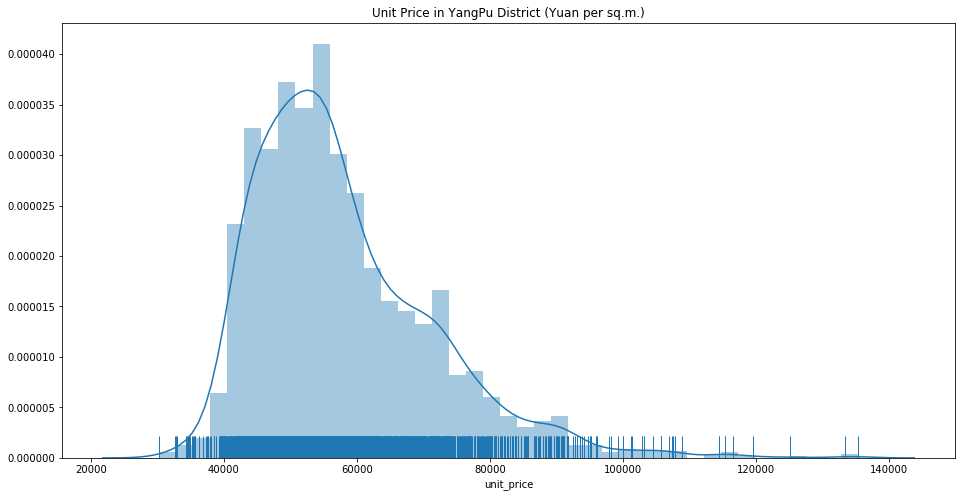

In [84]:
f,ax=plt.subplots(1,1,figsize=(16, 8))

sns.distplot(house['unit_price'], hist=True, kde=True, rug=True, ax=ax)

ax.set_title('Unit Price in YangPu District (Yuan per sq.m.)')
ax.set_ylabel('')

plt.show()

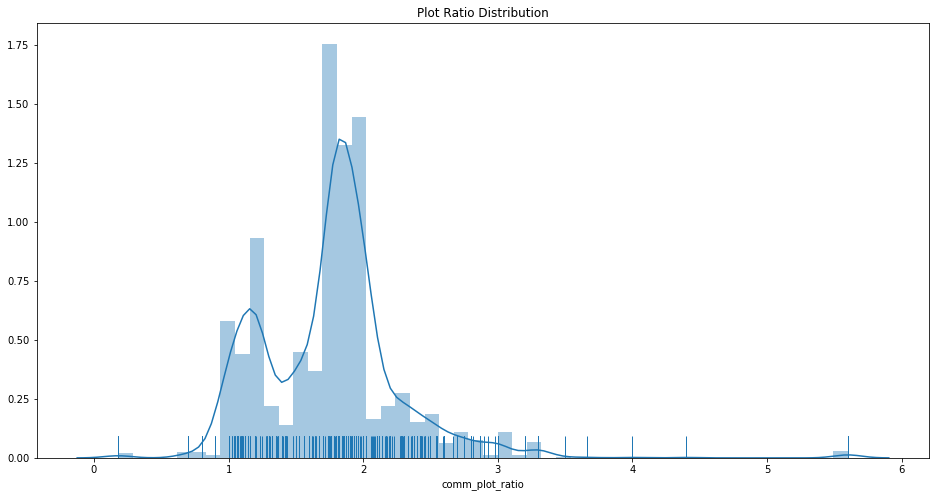

In [89]:
f,ax=plt.subplots(1,1,figsize=(16, 8))

sns.distplot(house['comm_plot_ratio'], hist=True, kde=True, rug=True, ax=ax)

ax.set_title('Plot Ratio Distribution')
ax.set_ylabel('')

plt.show()

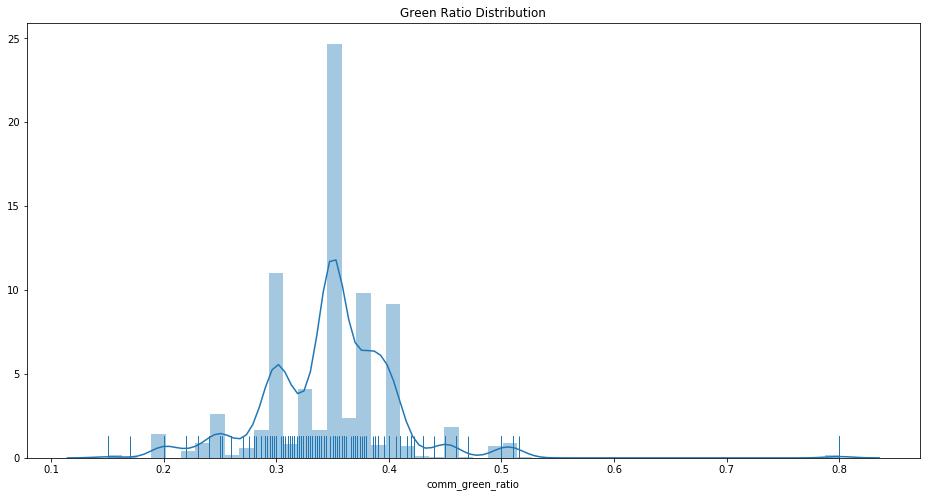

In [92]:
f,ax=plt.subplots(1,1,figsize=(16, 8))

sns.distplot(house['comm_green_ratio'], hist=True, kde=True, rug=True, ax=ax)

ax.set_title('Green Ratio Distribution')
ax.set_ylabel('')

plt.show()

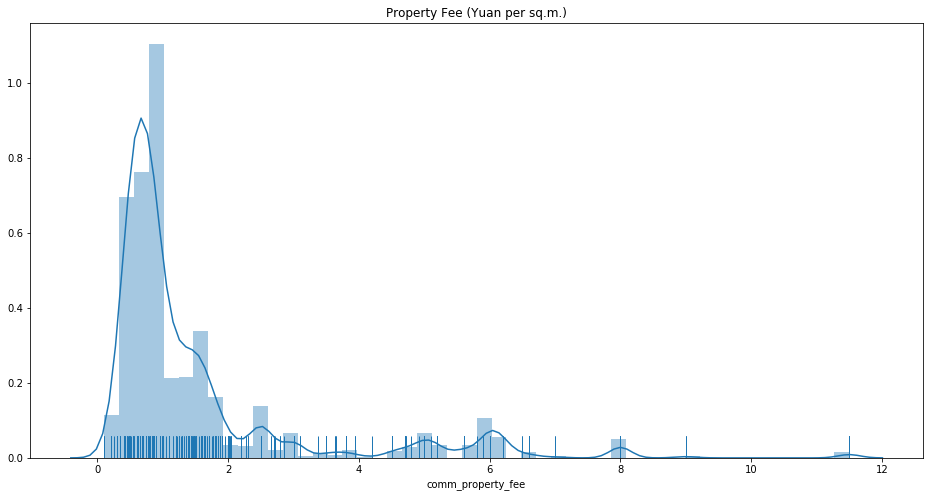

In [91]:
f,ax=plt.subplots(1,1,figsize=(16, 8))

sns.distplot(house['comm_property_fee'], hist=True, kde=True, rug=True, ax=ax)

ax.set_title('Property Fee (Yuan per sq.m.)')
ax.set_ylabel('')

plt.show()

In [93]:
house.to_csv('input/attemptation_yangpu_house.csv', index=False) # 留档

# **4 建模**

In [85]:
print(house.columns)

Index(['house_price', 'comm_area', 'comm_plot_ratio', 'comm_green_ratio',
       'comm_property_fee', 'comm_name', 'unit_price', 'block', 'house_area',
       'house_direction', 'house_type', 'house_decoration', 'house_lift',
       'house_room_num', 'house_hall_num', 'house_toilet_num', 'house_floor',
       'house_total_floor', 'trans', 'school', 'business', 'fundamental',
       'is_commcercial', 'year'],
      dtype='object')


In [95]:
predictors = ['comm_area', 'comm_plot_ratio', 'comm_green_ratio', 'comm_property_fee', 'house_area', \
              'house_decoration', 'house_lift', 'house_room_num', 'house_hall_num', 'house_toilet_num', \
              'house_floor', 'house_total_floor', 'trans', 'school', 'business', \
              'fundamental', 'is_commcercial', 'year']
up = ['unit_price']

X, y = house[predictors], house[up]

In [100]:
X.head()

,comm_area,comm_plot_ratio,comm_green_ratio,comm_property_fee,house_area,house_decoration,house_lift,house_room_num,house_hall_num,house_toilet_num,house_floor,house_total_floor,trans,school,business,fundamental,is_commcercial,year
0,29984.0,1.800,0.250,0.60,72.0,1,0,2,2,1,1.0,6.0,1,1,1,1,1,22
1,58000.0,1.860,0.250,0.84,66.9,2,0,2,1,1,1.0,6.0,1,0,0,1,1,21
2,45640.0,1.812,0.328,0.60,65.0,2,0,2,1,1,1.0,6.0,1,0,0,0,1,25
3,38400.0,2.000,0.400,0.55,60.0,1,0,2,1,1,1.0,6.0,0,0,1,1,1,26
4,36000.0,1.500,0.250,0.55,83.0,3,1,3,2,2,2.0,14.0,1,0,0,1,0,24


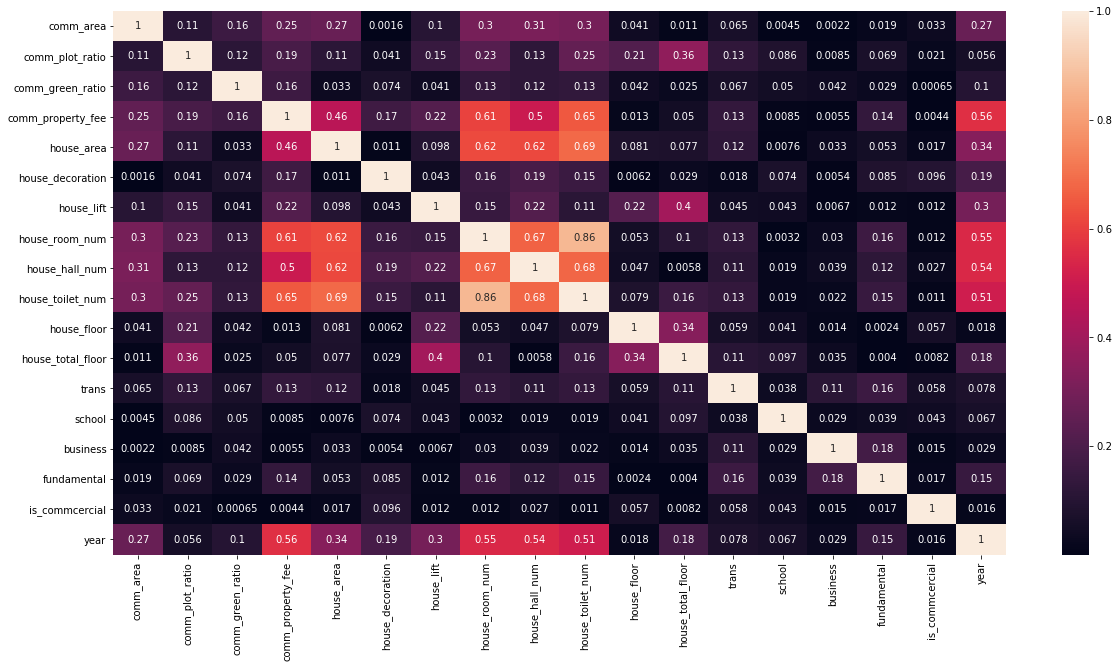

In [104]:
plt.figure(figsize=(20, 10))
sns.heatmap(X.corr().abs(),  annot=True)

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import preprocessing

In [109]:
def coef_plot(dataset, coef):
    """
    dataset：pd.DataFrame。仅仅用作传递列名；
    coef：feature_importances_。
    最后结果会传递一个图片和结果的df
    """
    yaxislabel = np.array(dataset.columns.tolist())[np.argsort(coef)]
    xaxislabel = np.array(coef.tolist())[np.argsort(coef)]

    plt.figure(figsize=(15,10), dpi=200)
    plt.barh(yaxislabel, xaxislabel)
    return pd.DataFrame({
                'label':dataset.columns.tolist(),
                'value':coef
            }), plt

R_square(LASSO):  0.28649091929666326


(                label         value
 0           comm_area   5151.990115
 1     comm_plot_ratio  -1663.025736
 2    comm_green_ratio   9547.050971
 3   comm_property_fee  20344.988457
 4          house_area   4574.631353
 5    house_decoration  -4657.479916
 6          house_lift    362.371343
 7      house_room_num   8292.429861
 8      house_hall_num    485.465807
 9    house_toilet_num  10348.838783
 10        house_floor   1669.377616
 11  house_total_floor  14764.549009
 12              trans   2370.648825
 13             school   3222.312909
 14           business    385.888009
 15        fundamental  -1826.802261
 16     is_commcercial  -1115.210470
 17               year  -6662.743012,
 <module 'matplotlib.pyplot' from 'c:\\users\\dushenghui\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>)

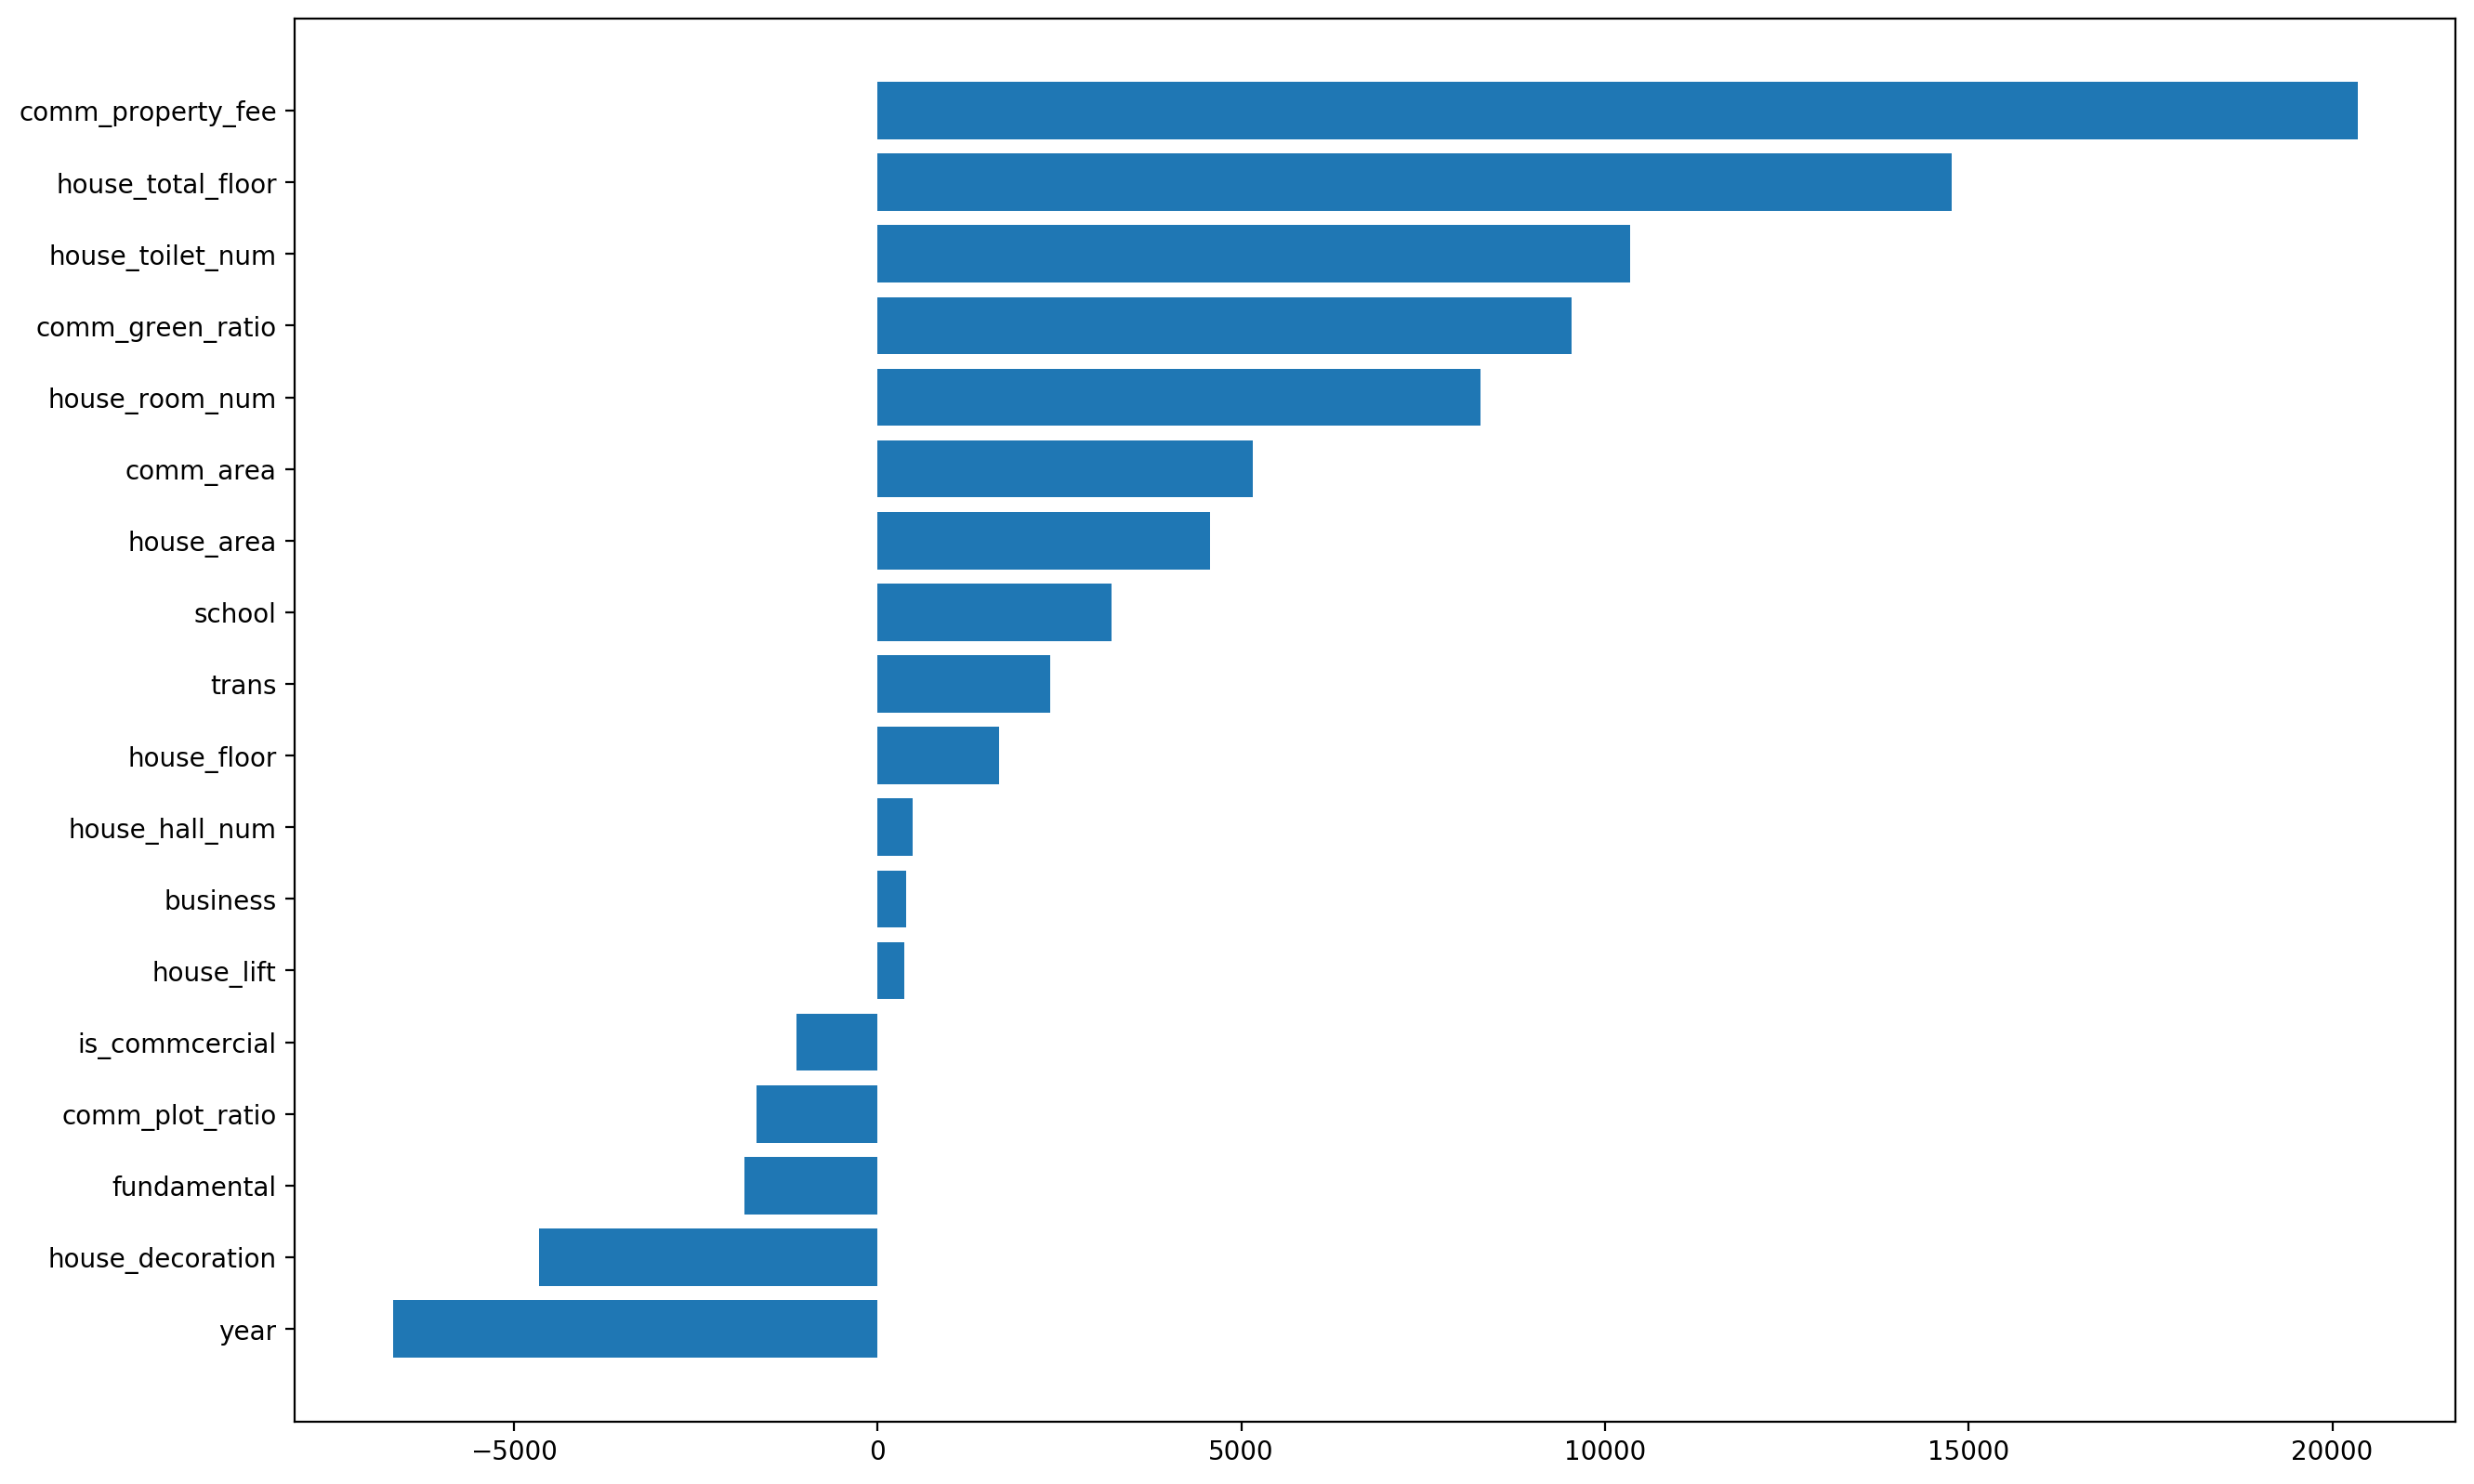

In [122]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train, X_test, y_train, y_true = train_test_split(min_max_scaler.fit_transform(X), y, test_size = 0.2, random_state = 42)

lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print('R_square(LASSO): ', r2_score(y_true = y_true, y_pred = y_pred))
coef_plot(X, lasso.coef_)

R_square(Linear Regression):  0.6029360121984211


(                label     value
 0           comm_area  0.078156
 1     comm_plot_ratio  0.076697
 2    comm_green_ratio  0.060567
 3   comm_property_fee  0.200005
 4          house_area  0.295749
 5    house_decoration  0.021825
 6          house_lift  0.008119
 7      house_room_num  0.018032
 8      house_hall_num  0.015857
 9    house_toilet_num  0.016957
 10        house_floor  0.020059
 11  house_total_floor  0.041424
 12              trans  0.006810
 13             school  0.012397
 14           business  0.008335
 15        fundamental  0.010289
 16     is_commcercial  0.011866
 17               year  0.096856,
 <module 'matplotlib.pyplot' from 'c:\\users\\dushenghui\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>)

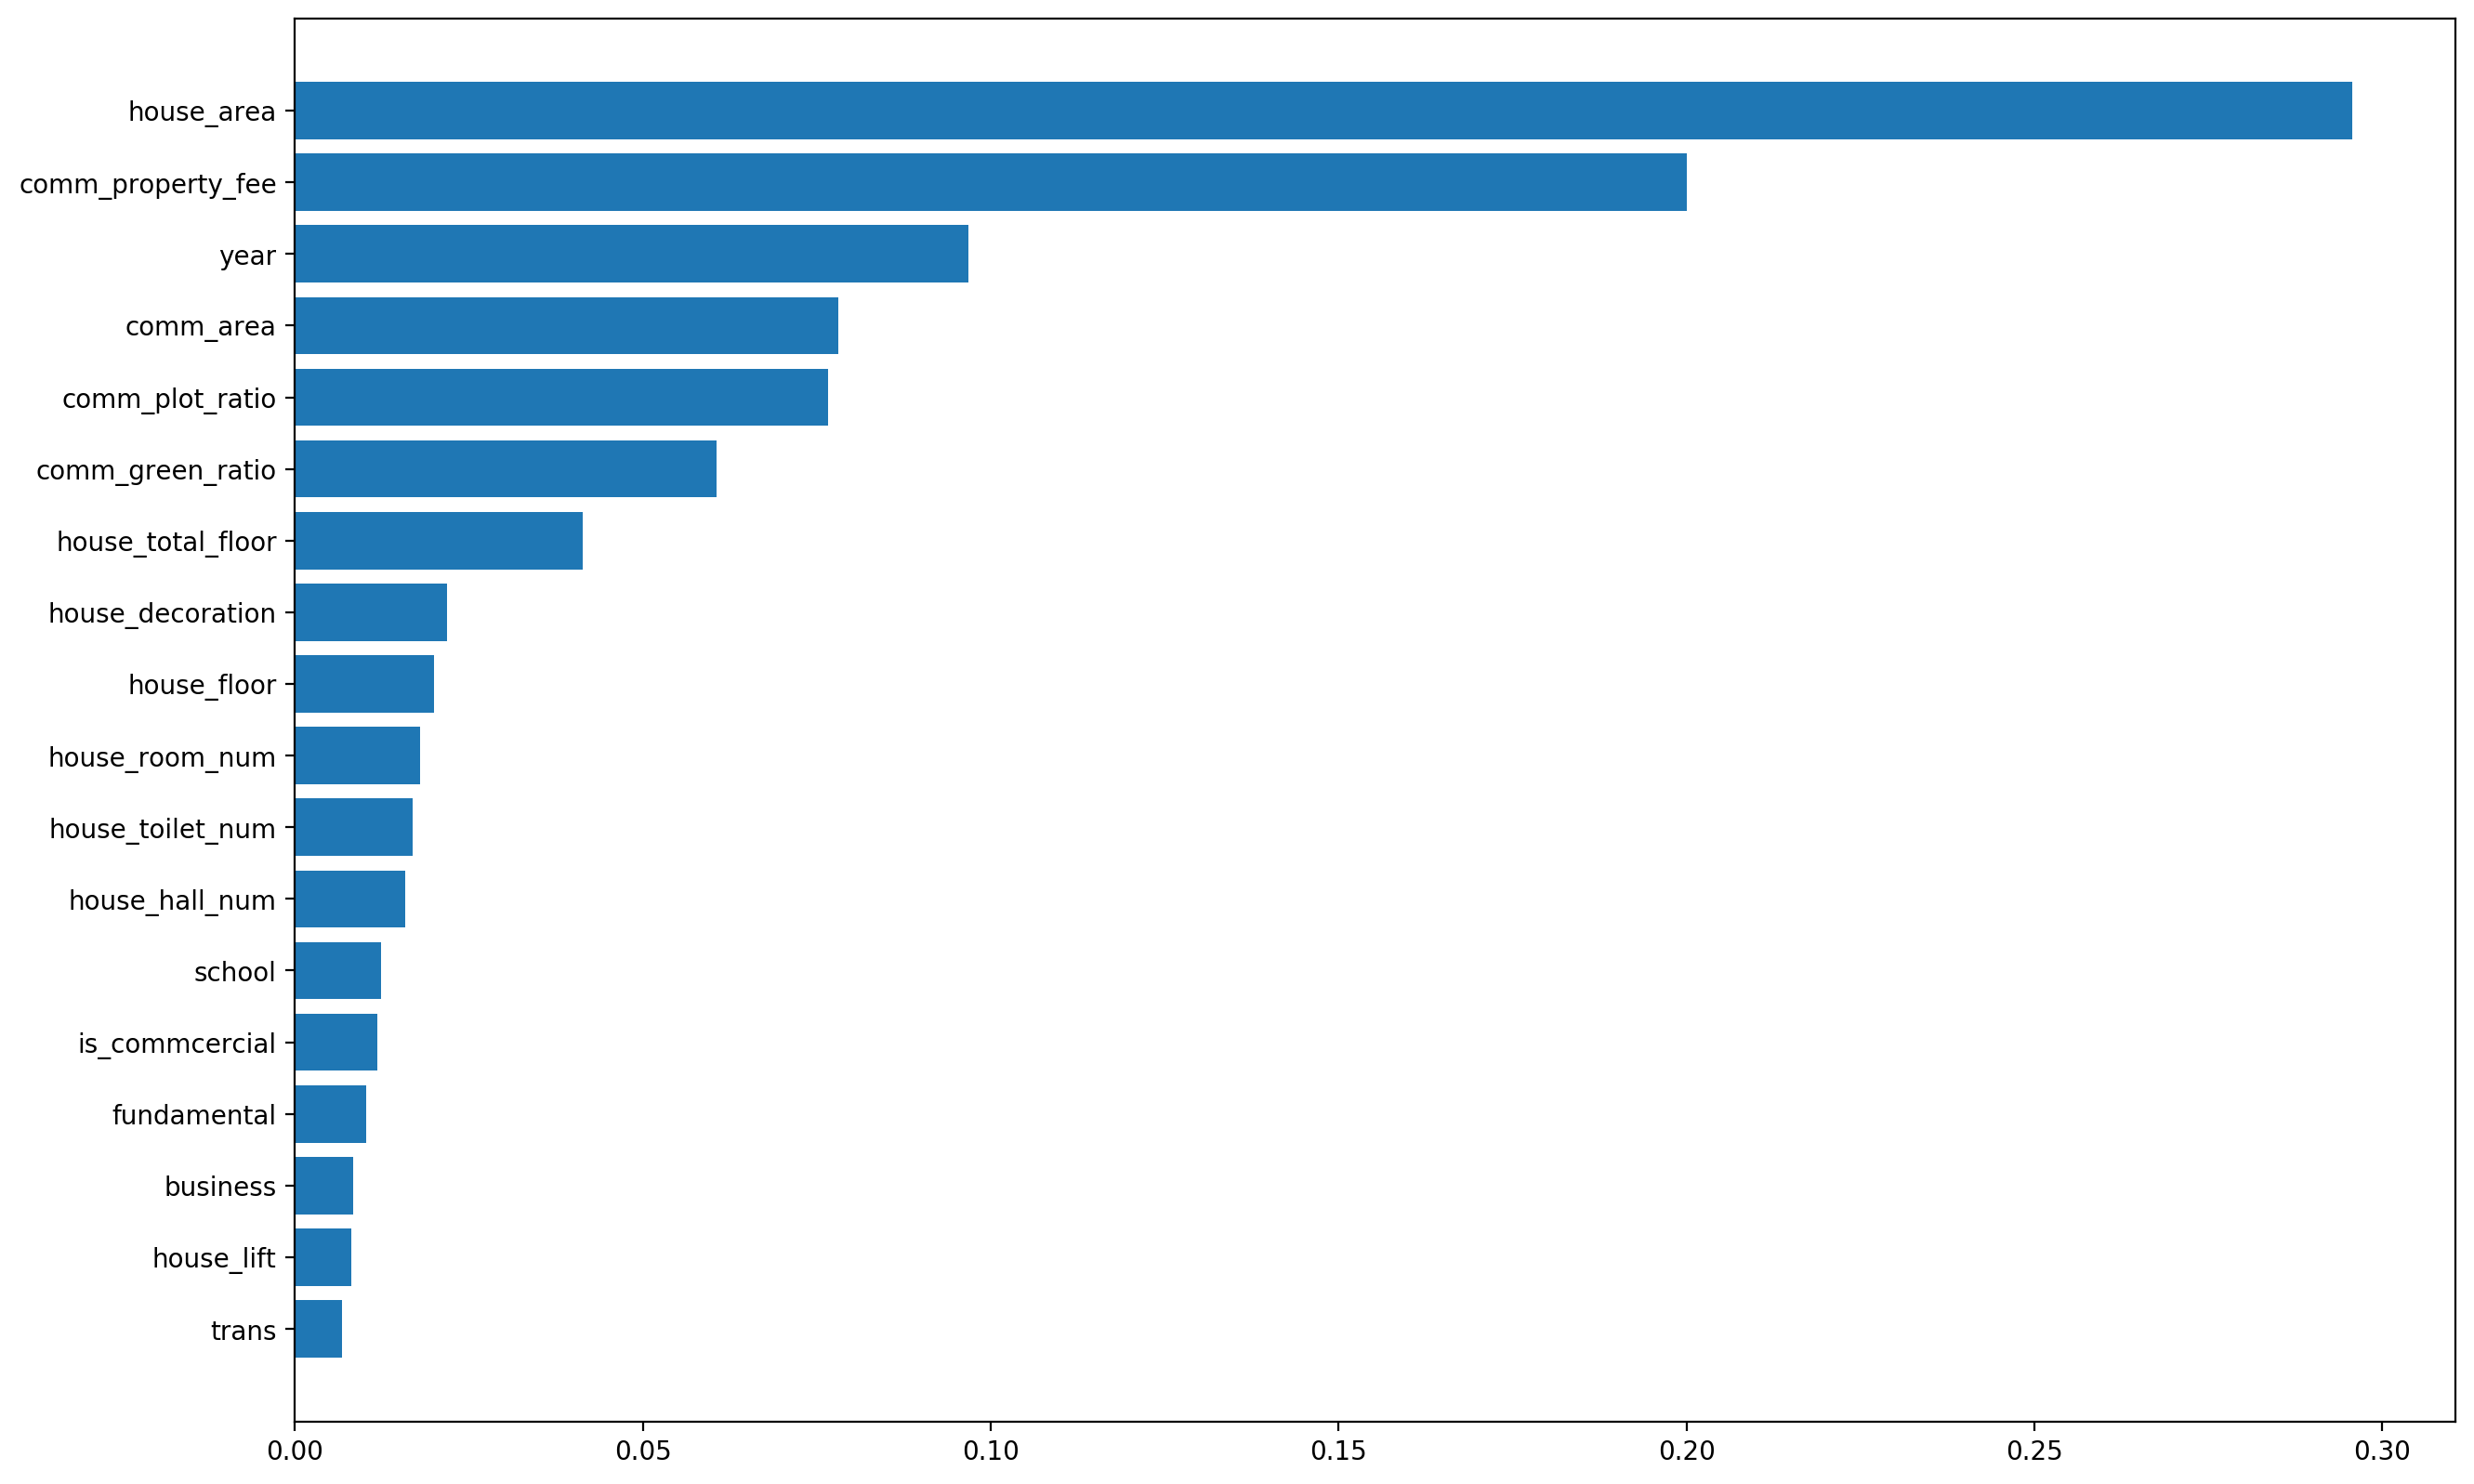

In [125]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_true = train_test_split(X, y, test_size = 0.2, random_state = 42)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('R_square(Random Forest): ', r2_score(y_true = y_true, y_pred = y_pred))

coef_plot(X, rfr.feature_importances_)